# RF forward modelling of sedimentary layers

In [74]:
from BayHunter.SynthObs import SynthObs
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

In [75]:
h = [5, 23, 8, 10]
vs = [2.7, 3.6, 3.8, 4.4]
vpvs = 1.73
rfdata = SynthObs.return_rfdata(h, vs, vpvs=vpvs, x=None)

In [78]:
def plot_1d_profile(layer_thicks, layer_velocities, ax=None):
    if ax is None:
        ax = plt.axes()
    layer_depths = np.cumsum(layer_thicks)
    layer_depths = np.concatenate(([0], layer_depths))
    if layer_depths[-1] == layer_depths[-2]:  # thickness of last layer was 0
        layer_depths[-1] += 10  # pad for the mantle
    z = np.repeat(layer_depths, 2)[1:-1]
    vs = np.repeat(layer_velocities, 2)
    ax.plot(vs, z)
    ax.invert_yaxis()
    ax.set_xlabel("$v_s$ (km/h)")
    ax.set_ylabel("Depth (km)")

def plot_rf(rfdata, ax=None):
    """
    rfdata is the output of SythObs.return_rfdata
    This will plot the P RF
    """
    if ax is None:
        ax =plt.axes()
    ax.plot(rfdata["prf"][0], rfdata["prf"][1])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("P RF")
    ax.set_yticklabels([])

def plot_synthetic(layer_thicks, layer_velocities, rfdata):
    fig = plt.figure(layout="tight")
    gs = GridSpec(3, 4, figure=fig)
    ax = fig.add_subplot(gs[:, 0])
    plot_1d_profile(layer_thicks, layer_velocities, ax=ax)
    ax = fig.add_subplot(gs[1, 1:])
    plot_rf(rfdata, ax=ax)
    return fig

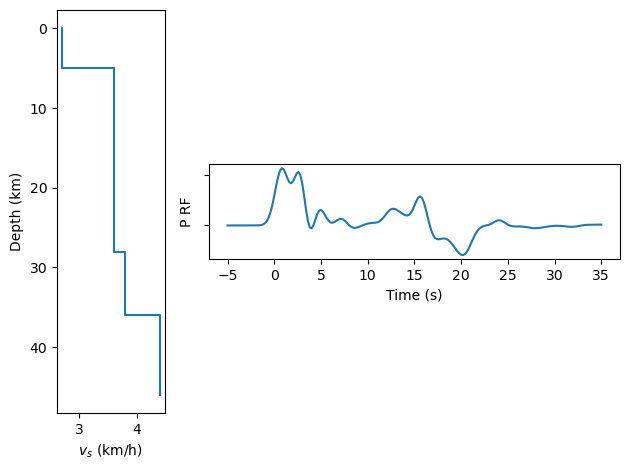

In [80]:
fig = plot_synthetic(h, vs, rfdata)